### Exploring the Role of Internal Replay in Mitigating Catastrophic Forgetting: A Brain-Inspired Approach to Continual Learning

20220175 Kim Jina

**Among all codes, this and main_cl_2.py are the code that are mainly related to the analysis made in the report.**

**Just in case, I also attached all the codes in the original repo together. Trained model can be found in /submission/store and /store/models. Figures in the report are in /submission/store/fig and can be ran via this ipynb.**


Since I use various types of trained models, each of the models are defined as following:

- trained_model_with_replay : br model using internal replay
- trained_model_witout_replay : br model not using internal replay
- trained_model_with_replay_si : br+si model using internal replay
- trained_model_without_replay_si : br+si model not using internal replay

In [33]:
!pip install numpy matplotlib scikit-learn umap-learn visdom

In [34]:
import sys
import os

# Add the brain folder to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap
from torch.utils.data import DataLoader
import define_models as define

import random

seed=12

random.seed(seed)
# Set seed for NumPy
np.random.seed(seed)
# Set seed for PyTorch
torch.manual_seed(seed)
# If using CUDA
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # For multi-GPU setups
# Ensure deterministic behavior (may impact performance)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [35]:
dict_with_replay = torch.load('../store/main_cl_2/train_nIFalse.pth', map_location='cpu')
dict_without_replay = torch.load('../store/main_cl_2/train_nITrue.pth', map_location='cpu')
dict_with_replay_si = torch.load('../store/main_cl_2/train_bir_si_nIFalse.pth', map_location='cpu')
dict_without_replay_si = torch.load('../store/main_cl_2/train_bir_si_nITrue.pth', map_location='cpu')

args_with_replay = dict_with_replay['args']
args_without_replay = dict_without_replay['args']
args_with_replay_si = dict_with_replay_si['args']
args_without_replay_si = dict_without_replay_si['args']

print(dict_with_replay['param_stamp'])
print(dict_without_replay['param_stamp'])
print(dict_with_replay_si['param_stamp'])
print(dict_without_replay_si['param_stamp'])

CIFAR100-N10-class--VAE=C3-5x16-bnH_F-1024x2000x2000_z100-GMM100pc_c100_cg0.7--i5000-lr0.0001-b256-pCvE-e100-fCvE--Hgen-Di2.0--H_MSE-s21
CIFAR100-N10-class--VAE=C3-5x16-bn_F-1024x2000x2000_z100-GMM100pc_c100_cg0.9--i5000-lr0.0001-b256-pCvE-e100-fCvE--gen-Di2.0--MSE-s21_nITrue
CIFAR100-N10-class--VAE=C3-5x16-bnH_F-1024x2000x2000_z100-GMM100pc_c100_cg0.6--i5000-lr0.0001-b256-pCvE-e100-fCvE--SI100000000.0-0.1--Hgen-Di2.0--H_MSE-s21
CIFAR100-N10-class--VAE=C3-5x16-bn_F-1024x2000x2000_z100-GMM100pc_c100_cg0.8--i5000-lr0.0001-b256-pCvE-e100-fCvE--SI100000000.0-0.1--gen-Di2.0--MSE-s21_nITrue


/tmp/ipykernel_3296869/1871385637.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dict_with_replay = torch.load('../store/main_cl_2/train_nIFalse.pth', map_location='cpu

In [36]:
trained_model_with_replay_dict = torch.load('../store/models/mM-'+dict_with_replay['param_stamp'], map_location='cpu')
trained_model_without_replay_dict = torch.load('../store/models/mM-'+dict_without_replay['param_stamp'], map_location='cpu')
trained_model_with_replay_si_dict = torch.load('../store/models/mM-'+dict_with_replay_si['param_stamp'], map_location='cpu')
trained_model_without_replay_si_dict = torch.load('../store/models/mM-'+dict_without_replay_si['param_stamp'], map_location='cpu')

/tmp/ipykernel_3296869/1667618884.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_model_with_replay_dict = torch.load('../store/models/mM-'+dict_with_replay['par

In [37]:
from data.load import get_multitask_experiment
import utils

(train_datasets, test_datasets), config, classes_per_task = get_multitask_experiment(
        name=dict_with_replay['args'].experiment, scenario=dict_with_replay['args'].scenario, tasks=dict_with_replay['args'].tasks, data_dir=dict_with_replay['args'].d_dir,
        normalize=True if utils.checkattr(dict_with_replay['args'], "normalize") else False,
        augment=True if utils.checkattr(dict_with_replay['args'], "augment") else False,
        verbose=False, exception=True if dict_with_replay['args'].seed<10 else False, only_test=(not dict_with_replay['args'].train)
    )

Files already downloaded and verified
Files already downloaded and verified


### 1. Measuring the Test Accuracy

In [38]:
from torch import optim
from models.cl.continual_learner import ContinualLearner


cuda = torch.cuda.is_available() and args_without_replay.cuda
device = torch.device("cuda" if cuda else "cpu")

def get_model(args):
    model = define.define_autoencoder(args=args, config=config, device=device)
    model = define.init_params(model, args)
    # - freeze weights of conv-layers?
    if utils.checkattr(args, "freeze_convE"):
        for param in model.convE.parameters():
            param.requires_grad = False
    if utils.checkattr(args, 'feedback') and utils.checkattr(args, "freeze_convD"):
        for param in model.convD.parameters():
            param.requires_grad = False

    # Define optimizer (only optimize parameters that "requires_grad")
    model.optim_list = [
        {'params': filter(lambda p: p.requires_grad, model.parameters()), 'lr': args.lr},
    ]
    model.optimizer = optim.Adam(model.optim_list, betas=(0.9, 0.999))
    
    if isinstance(model, ContinualLearner) and hasattr(args, 'replay') and not args.replay=="none":
        model.replay_targets = "soft" if args.distill else "hard"
        model.KD_temp = args.temp
        
    return model

In [39]:
trained_model_with_replay = get_model(args_with_replay)
trained_model_without_replay = get_model(args_without_replay)
trained_model_with_replay_si = get_model(args_with_replay_si)
trained_model_without_replay_si = get_model(args_without_replay_si)

/d1/mlai/brain-inspired-replay/utils.py:110: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


 --> loaded checkpoint of C3-5x16-bn-e100 from ./store/models
 --> loaded checkpoint of C3-5x16-bn-e100 from ./store/models
 --> loaded checkpoint of C3-5x16-bn-e100 from ./store/models
 --> loaded checkpoint of C3-5x16-bn-e100 from ./store/models


#### 1-1. Evaluation of the Classifier

In [40]:
# method_dict
# for seed in seed_list:
#     args.seed = seed
#     final_accs, final_average_accs, initial_accs, average_initial_accs = run(args, verbose=True)
        
#     method_dict = {}
#     method_dict[seed] = {
#         'final_accs' : final_accs,
#         'final_average_accs' : final_average_accs,
#         'initial_accs' : initial_accs,
#         'average_initial_accs' : average_initial_accs
#     }

method_dict_with_replay = torch.load('../store/main_cl_2/accuracy_nIFalse.pth', map_location='cpu')
method_dict_without_replay = torch.load('../store/main_cl_2/accuracy_nITrue.pth', map_location='cpu')
method_dict_with_replay_si = torch.load('../store/main_cl_2/accuracy_bir_si_nIFalse.pth', map_location='cpu')
method_dict_without_replay_si = torch.load('../store/main_cl_2/accuracy_bir_si_nITrue.pth', map_location='cpu')

/tmp/ipykernel_3296869/222640452.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  method_dict_with_replay = torch.load('../store/main_cl_2/accuracy_nIFalse.pth', map_loc

In [41]:
print(method_dict_with_replay.keys())
print(method_dict_without_replay.keys())
print(method_dict_with_replay_si.keys())
print(method_dict_without_replay_si.keys())

dict_keys([16, 17, 18, 19, 20, 21, 12, 13, 14, 15])
dict_keys([16, 17, 18, 19, 20, 21, 12, 13, 14, 15])
dict_keys([16, 17, 18, 19, 20, 21, 12, 13, 14, 15])
dict_keys([16, 17, 18, 19, 20, 21, 12, 13, 14, 15])


In [42]:
def get_accuracys(method_dict_with_replay, method_dict_without_replay):
    task = len(method_dict_with_replay[16]['final_accs'])
    n_seeds = len(method_dict_with_replay.keys())

    init_acc_seeds_with_replay = [0] * task
    final_acc_seeds_with_replay = [0] * task
    init_avg_acc_seeds_with_replay = 0
    final_avg_acc_seeds_with_replay = 0

    init_acc_seeds_without_replay = [0] * task
    final_acc_seeds_without_replay = [0] * task
    init_avg_acc_seeds_without_replay = 0
    final_avg_acc_seeds_without_replay = 0

    for j in method_dict_with_replay.keys():
        for i in range(task):
            init_acc_seeds_with_replay[i] += method_dict_with_replay[j]['initial_accs'][i]
            final_acc_seeds_with_replay[i] += method_dict_with_replay[j]['final_accs'][i]
            init_acc_seeds_without_replay[i] += method_dict_without_replay[j]['initial_accs'][i]
            final_acc_seeds_without_replay[i] += method_dict_without_replay[j]['final_accs'][i]
        init_avg_acc_seeds_with_replay += method_dict_with_replay[j]['initial_average_accs']
        final_avg_acc_seeds_with_replay += method_dict_with_replay[j]['final_average_accs']
        init_avg_acc_seeds_without_replay += method_dict_without_replay[j]['initial_average_accs']
        final_avg_acc_seeds_without_replay += method_dict_without_replay[j]['final_average_accs']
        
    init_acc_seeds_with_replay = [x/n_seeds for x in init_acc_seeds_with_replay]
    final_acc_seeds_with_replay = [x/n_seeds for x in final_acc_seeds_with_replay]
    init_acc_seeds_without_replay = [x/n_seeds for x in init_acc_seeds_without_replay]
    final_acc_seeds_without_replay = [x/n_seeds for x in final_acc_seeds_without_replay]

    init_avg_acc_seeds_with_replay /=n_seeds
    final_avg_acc_seeds_with_replay /= n_seeds
    init_avg_acc_seeds_without_replay /= n_seeds
    final_avg_acc_seeds_without_replay /= n_seeds

    print(init_acc_seeds_with_replay)
    print(final_acc_seeds_with_replay)
    print(init_acc_seeds_without_replay)
    print(final_acc_seeds_without_replay)
    print(init_avg_acc_seeds_with_replay)
    print(final_avg_acc_seeds_with_replay)
    print(init_avg_acc_seeds_without_replay)
    print(final_avg_acc_seeds_without_replay)

    print(init_avg_acc_seeds_with_replay, sum(init_acc_seeds_with_replay)/task)
    print(final_avg_acc_seeds_with_replay, sum(final_acc_seeds_with_replay)/task)
    print(init_avg_acc_seeds_without_replay, sum(init_acc_seeds_without_replay)/task)
    print(final_avg_acc_seeds_without_replay, sum(final_acc_seeds_without_replay)/task)
    
    return init_acc_seeds_with_replay, final_acc_seeds_with_replay, init_acc_seeds_without_replay, final_acc_seeds_without_replay,\
        init_avg_acc_seeds_with_replay, final_avg_acc_seeds_with_replay, init_avg_acc_seeds_without_replay, final_avg_acc_seeds_without_replay

In [43]:
init_acc_seeds_with_replay, final_acc_seeds_with_replay, init_acc_seeds_without_replay, final_acc_seeds_without_replay,\
        init_avg_acc_seeds_with_replay, final_avg_acc_seeds_with_replay, init_avg_acc_seeds_without_replay, final_avg_acc_seeds_without_replay\
            = get_accuracys(method_dict_with_replay, method_dict_without_replay)

[0.7983, 0.7378, 0.7197, 0.7085, 0.6849, 0.7195, 0.6973999999999998, 0.6893999999999999, 0.6804000000000001, 0.6763]
[0.0581, 0.0443, 0.049699999999999994, 0.0684, 0.08070000000000001, 0.1426, 0.2142, 0.32070000000000004, 0.46580000000000005, 0.6763]
[0.7979, 0.7938000000000001, 0.7859999999999999, 0.7785, 0.7605999999999999, 0.7790000000000001, 0.7654000000000001, 0.7634000000000001, 0.7588, 0.7585]
[0.018999999999999996, 0.014500000000000002, 0.0166, 0.022899999999999997, 0.015600000000000003, 0.04530000000000001, 0.0484, 0.07680000000000001, 0.1385, 0.7585]
0.71122
0.21208
0.77419
0.11561000000000002
0.71122 0.7112200000000001
0.21208 0.21208
0.77419 0.7741899999999999
0.11561000000000002 0.11560999999999999


In [44]:
init_acc_seeds_with_replay_si, final_acc_seeds_with_replay_si, init_acc_seeds_without_replay_si, final_acc_seeds_without_replay_si,\
        init_avg_acc_seeds_with_replay_si, final_avg_acc_seeds_with_replay_si, init_avg_acc_seeds_without_replay_si, final_avg_acc_seeds_without_replay_si\
            = get_accuracys(method_dict_with_replay_si, method_dict_without_replay_si)

[0.7979999999999999, 0.6552, 0.5723, 0.5178, 0.46040000000000003, 0.4908, 0.4499000000000001, 0.441, 0.434, 0.4354]
[0.36079999999999995, 0.29090000000000005, 0.2982, 0.316, 0.30490000000000006, 0.36560000000000004, 0.363, 0.38719999999999993, 0.40499999999999997, 0.4354]
[0.7978999999999998, 0.7258, 0.7121, 0.6801999999999999, 0.6476000000000001, 0.6460999999999999, 0.6289, 0.6024, 0.5817, 0.5805]
[0.056299999999999996, 0.0402, 0.039799999999999995, 0.08080000000000001, 0.09419999999999999, 0.15510000000000002, 0.1929, 0.2952, 0.3924, 0.5805]
0.5254800000000001
0.35269999999999996
0.66032
0.19274
0.5254800000000001 0.5254800000000002
0.35269999999999996 0.3527
0.66032 0.6603199999999999
0.19274 0.19274


In [97]:
import matplotlib.pyplot as plt
import numpy as np

def plot_with_without_replay_acc_per_task(with_replay_list, with_replay_avg, without_replay_list, without_replay_avg, \
    with_replay_list_si, with_replay_avg_si, without_replay_list_si, without_replay_avg_si, \
        plot_name, y_axis='Test Accuracy'):
    # Tasks
    tasks = np.arange(1, len(with_replay_list) + 1)

    # Plot
    plt.figure(figsize=(10, 6))

    # Plot individual accuracies
    plt.plot(tasks, with_replay_list, marker='o', label="BIR (w/ IR)", color='#024CAA')
    plt.plot(tasks, without_replay_list, marker='s', label="BIR (w/o IR)", color='#F0A8D0')
    plt.plot(tasks, with_replay_list_si, marker='o', label="BIR+SI (w/ IR)", color='#134B70')
    plt.plot(tasks, without_replay_list_si, marker='s', label="BIR+SI (w/o IR)", color='#DA7297')

    # Plot average accuracies as dashed lines
    plt.axhline(y=with_replay_avg, color='#024CAA', linestyle='--', ) # label="Average Accuracy (With Replay)"
    plt.axhline(y=without_replay_avg, color='#F0A8D0', linestyle='--', ) # label="Average Accuracy (Without Replay)"
    plt.axhline(y=with_replay_avg_si, color='#134B70', linestyle='--', ) # label="Average Accuracy (With Replay)"
    plt.axhline(y=without_replay_avg_si, color='#DA7297', linestyle='--', ) # label="Average Accuracy (Without Replay)"

    # Labels and Title
    plt.title(plot_name)
    plt.xlabel("Task")
    plt.ylabel(y_axis)
    plt.legend()
    plt.grid(alpha=0.5)
    plt.xticks(tasks)

    os.makedirs("./store/fig/", exist_ok=True)
    plt.savefig(f"./store/fig/{plot_name}.pdf")

    # Show Plot
    %matplotlib inline
    plt.tight_layout()
    plt.show()
    


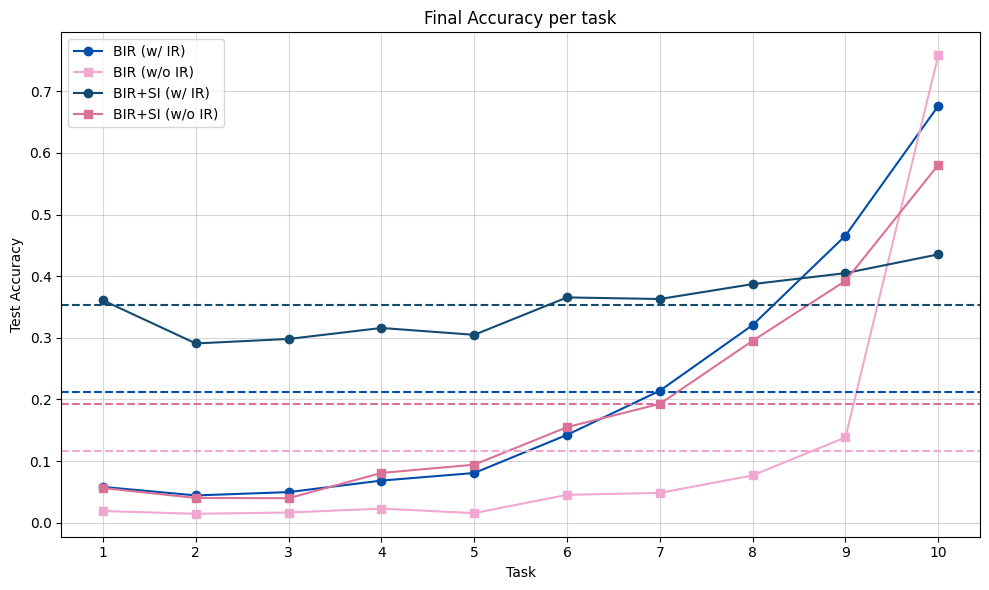

In [98]:
plot_with_without_replay_acc_per_task(final_acc_seeds_with_replay, \
    final_avg_acc_seeds_with_replay, \
        final_acc_seeds_without_replay, \
            final_avg_acc_seeds_without_replay, \
                final_acc_seeds_with_replay_si, \
                    final_avg_acc_seeds_with_replay_si, \
                        final_acc_seeds_without_replay_si, \
                            final_avg_acc_seeds_without_replay_si, \
                "Final Accuracy per task")

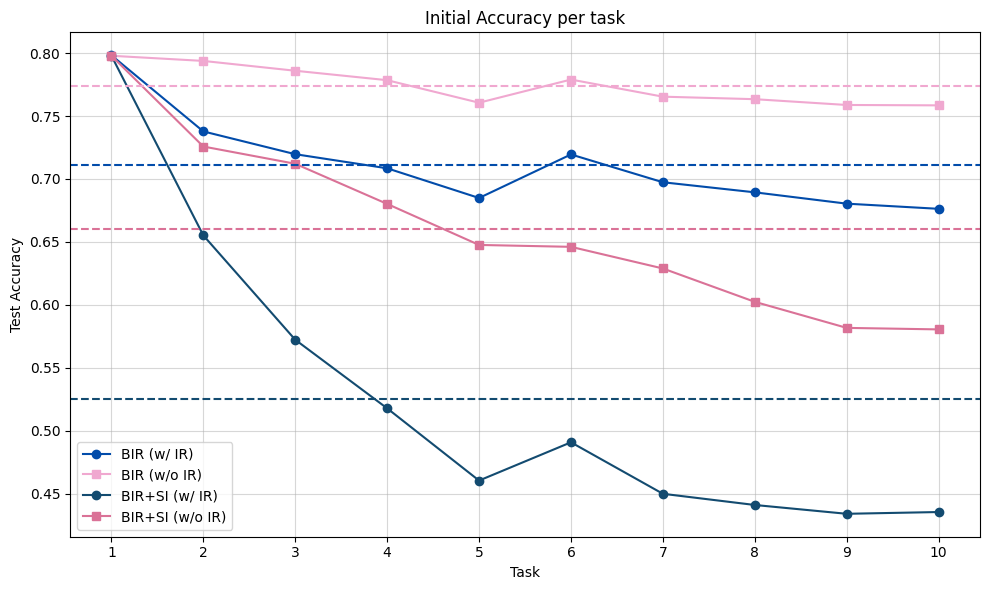

In [99]:
# w/o internal replay got better initial accuracy

plot_with_without_replay_acc_per_task(init_acc_seeds_with_replay, \
    init_avg_acc_seeds_with_replay, \
        init_acc_seeds_without_replay, \
            init_avg_acc_seeds_without_replay, \
                init_acc_seeds_with_replay_si, \
    init_avg_acc_seeds_with_replay_si, \
        init_acc_seeds_without_replay_si, \
            init_avg_acc_seeds_without_replay_si, \
                "Initial Accuracy per task")

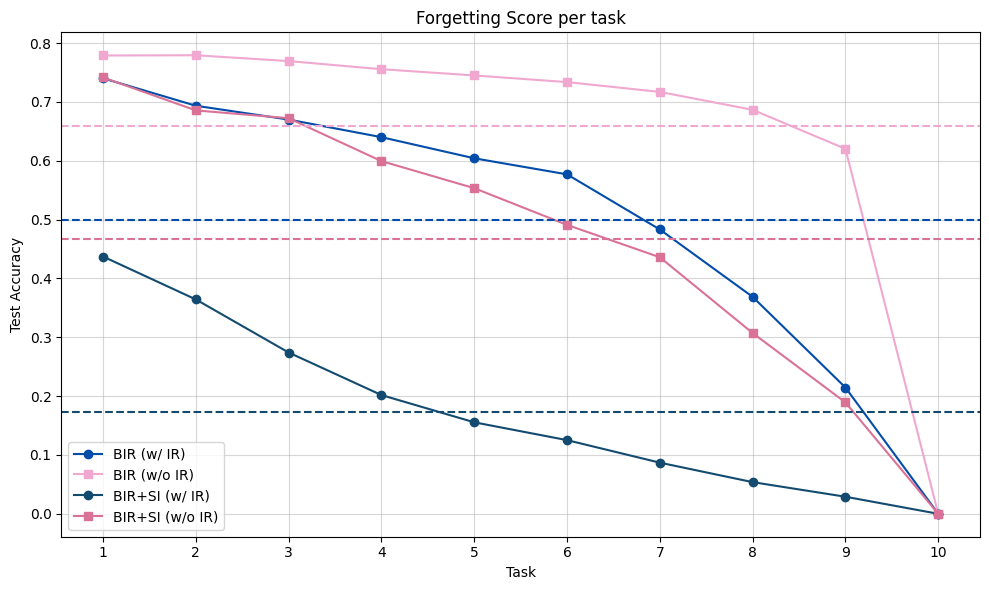

In [100]:
# w/o internal replay rapidly decrease, the just before task (9th) also has high forgetting rate
# has room for improvement since the decrease rate in w/ internal replay is also not small (=> final acc : around 0.2)

with_replay_i_f = [init_acc_seeds_with_replay[x]-final_acc_seeds_with_replay[x] for x in range(len(init_acc_seeds_with_replay))]
without_replay_i_f = [init_acc_seeds_without_replay[x]-final_acc_seeds_without_replay[x] for x in range(len(final_acc_seeds_without_replay))]

with_replay_i_f_si = [init_acc_seeds_with_replay_si[x]-final_acc_seeds_with_replay_si[x] for x in range(len(init_acc_seeds_with_replay_si))]
without_replay_i_f_si = [init_acc_seeds_without_replay_si[x]-final_acc_seeds_without_replay_si[x] for x in range(len(final_acc_seeds_without_replay_si))]

plot_with_without_replay_acc_per_task(with_replay_i_f, \
    init_avg_acc_seeds_with_replay-final_avg_acc_seeds_with_replay, \
        without_replay_i_f, \
            init_avg_acc_seeds_without_replay-final_avg_acc_seeds_without_replay, \
                with_replay_i_f_si, \
    init_avg_acc_seeds_with_replay_si-final_avg_acc_seeds_with_replay_si, \
        without_replay_i_f_si, \
            init_avg_acc_seeds_without_replay_si-final_avg_acc_seeds_without_replay_si, \
                "Forgetting Score per task")

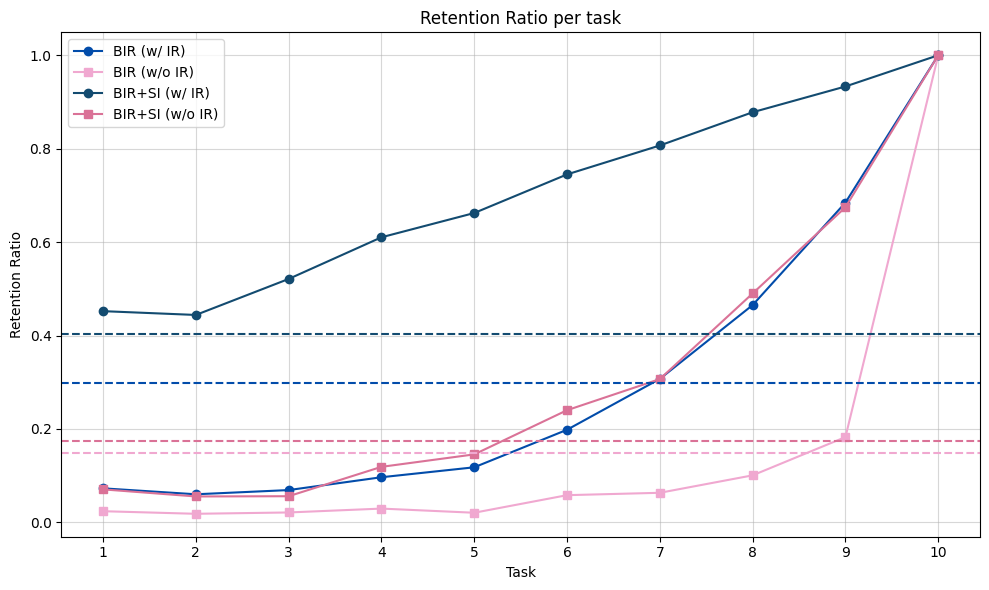

In [101]:
# w/o internal replay rapidly decrease, the just before task (9th) also has low retention rate (i.e. high forgetting rate)
# has room for improvement since the decrease rate in w/ internal replay is also not small (=> final acc : around 0.2)

with_replay_forget_rate = [final_acc_seeds_with_replay[x]/init_acc_seeds_with_replay[x] for x in range(len(init_acc_seeds_with_replay))]
without_replay_forget_rate = [final_acc_seeds_without_replay[x]/init_acc_seeds_without_replay[x] for x in range(len(init_acc_seeds_with_replay))]

with_replay_forget_rate_si = [final_acc_seeds_with_replay_si[x]/init_acc_seeds_with_replay_si[x] for x in range(len(init_acc_seeds_with_replay_si))]
without_replay_forget_rate_si = [final_acc_seeds_without_replay_si[x]/init_acc_seeds_without_replay_si[x] for x in range(len(init_acc_seeds_with_replay_si))]


plot_with_without_replay_acc_per_task(with_replay_forget_rate, \
    final_avg_acc_seeds_with_replay/init_avg_acc_seeds_with_replay, \
        without_replay_forget_rate, \
            final_avg_acc_seeds_without_replay/init_avg_acc_seeds_without_replay, \
                with_replay_forget_rate_si, \
    final_avg_acc_seeds_with_replay/init_avg_acc_seeds_with_replay_si, \
        without_replay_forget_rate_si, \
            final_avg_acc_seeds_without_replay/init_avg_acc_seeds_without_replay_si, \
                "Retention Ratio per task", y_axis="Retention Ratio")

#### 1-2. Additional analysis (log-likelihood, reconstruction error)

In [50]:
import numpy as np
import os
from scipy.stats import entropy
import torch
from torch import optim
from torch.utils.data import ConcatDataset
from torch.nn import functional as F

# -custom-written libraries
import options
import utils
import define_models as define
from data.load import get_multitask_experiment
from eval import evaluate
from eval import callbacks as cb
import eval.precision_recall as pr
import eval.fid as fid
from train import train_cl
from param_stamp import get_param_stamp
from models.cl.continual_learner import ContinualLearner

def additional_analysis(model, args, param_stamp, verbose=True):
    # Dataset and model to be used
    test_set = ConcatDataset(test_datasets)
    gen_model = model #  if utils.checkattr(args, 'feedback') else generator
    gen_model.eval()

    # Evaluate log-likelihood of generative model on combined test-set (with S=100 importance samples per datapoint)
    ll_per_datapoint = gen_model.estimate_loglikelihood(test_set, S=100, batch_size=args.batch)
    if verbose:
        print('=> Log-likelihood on test set: {:.4f} +/- {:.4f}\n'.format(
            np.mean(ll_per_datapoint), np.sqrt(np.var(ll_per_datapoint))
        ))

    # Evaluate reconstruction error (averaged over number of input units)
    re_per_datapoint = gen_model.calculate_recon_error(test_set, batch_size=args.batch, average=True)
    if verbose:
        print('=> Reconstruction error (per input unit) on test set: {:.4f} +/- {:.4f}\n'.format(
            np.mean(re_per_datapoint), np.sqrt(np.var(re_per_datapoint))
        ))
        
    # Try loading the classifier (our substitute for InceptionNet) for calculating IS, FID and Recall & Precision
    # -define model
    config['classes'] = 100
    pretrained_classifier = define.define_classifier(args=args, config=config, device=device)
    pretrained_classifier.hidden = False
    # -load pretrained weights
    eval_tag = "" if args.eval_tag=="none" else "-{}".format(args.eval_tag)
    try:
        utils.load_checkpoint(pretrained_classifier, args.m_dir, verbose=True,
                                name="{}{}".format(pretrained_classifier.name, eval_tag))
        FileFound = True
    except FileNotFoundError:
        if verbose:
            print("= Could not find model {}{} in {}".format(pretrained_classifier.name, eval_tag, args.m_dir))
            print("= IS, FID and Precision & Recall not computed!")
        FileFound = False
    pretrained_classifier.eval()

    # Only continue with computing these measures if the requested classifier network (using --eval-tag) was found
    if FileFound:
        # Preparations
        total_n = len(test_set)
        n_repeats = int(np.ceil(total_n/args.batch))
        # -sample data from generator (for IS, FID and Precision & Recall)
        gen_x = gen_model.sample(size=total_n, only_x=True)
        # -generate predictions for generated data (for IS)
        gen_pred = []
        for i in range(n_repeats):
            x = gen_x[(i*args.batch): int(min(((i+1)*args.batch), total_n))]
            with torch.no_grad():
                gen_pred.append(F.softmax(
                    pretrained_classifier.hidden_to_output(x) if args.hidden else pretrained_classifier(x), dim=1
                ).cpu().numpy())
        gen_pred = np.concatenate(gen_pred)
        # -generate embeddings for generated data (for FID and Precision & Recall)
        gen_emb = []
        for i in range(n_repeats):
            with torch.no_grad():
                gen_emb.append(pretrained_classifier.feature_extractor(
                    gen_x[(i*args.batch):int(min(((i+1)*args.batch), total_n))], from_hidden=args.hidden
                ).cpu().numpy())
        gen_emb = np.concatenate(gen_emb)
        # -generate embeddings for test data (for FID and Precision & Recall)
        data_loader = utils.get_data_loader(test_set, batch_size=args.batch, cuda=cuda)
        real_emb = []
        for real_x, _ in data_loader:
            with torch.no_grad():
                real_emb.append(pretrained_classifier.feature_extractor(real_x.to(device)).cpu().numpy())
        real_emb = np.concatenate(real_emb)

        # Calculate "Inception Score" (IS)
        py = gen_pred.mean(axis=0)
        is_per_datapoint = []
        for i in range(len(gen_pred)):
            pyx = gen_pred[i, :]
            is_per_datapoint.append(entropy(pyx, py))
        IS = np.exp(np.mean(is_per_datapoint))
        if verbose:
            print('=> Inception Score = {:.4f}\n'.format(IS))

        ## Calculate "Frechet Inception Distance" (FID)
        FID = fid.calculate_fid_from_embedding(gen_emb, real_emb)
        if verbose:
            print('=> Frechet Inception Distance = {:.4f}\n'.format(FID))

        # Calculate "Precision & Recall"-curves
        precision, recall = pr.compute_prd_from_embedding(gen_emb, real_emb)
                
    return ll_per_datapoint, re_per_datapoint, IS, FID, precision, recall

In [51]:
ll_per_datapoint_with_replay, \
    re_per_datapoint_with_replay, \
        IS_with_replay, \
            FID_with_replay, \
                precision_with_replay, \
                    recall_with_replay = additional_analysis(trained_model_with_replay, \
                                                                dict_with_replay['args'], \
                                                                    dict_with_replay['param_stamp'], \
                                                                        verbose=True)

=> Log-likelihood on test set: -388.2534 +/- 149.8071

=> Reconstruction error (per input unit) on test set: 0.3223 +/- 0.1448

 --> loaded checkpoint of C3-5x16-bn_F-1024x2000x2000_c100 from ./store/models


/d1/mlai/brain-inspired-replay/utils.py:110: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


=> Inception Score = 1.0026

=> Frechet Inception Distance = 2524.5693



In [52]:
ll_per_datapoint_without_replay, \
    re_per_datapoint_without_replay, \
        IS_without_replay, \
            FID_without_replay, \
                precision_without_replay, \
                    recall_without_replay = additional_analysis(trained_model_without_replay, \
                                                                dict_without_replay['args'], \
                                                                    dict_without_replay['param_stamp'], \
                                                                        verbose=True)

=> Log-likelihood on test set: -1627.0315 +/- 876.5558

=> Reconstruction error (per input unit) on test set: 0.5105 +/- 0.2852

 --> loaded checkpoint of C3-5x16-bn_F-1024x2000x2000_c100 from ./store/models


/d1/mlai/brain-inspired-replay/utils.py:110: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


=> Inception Score = 1.0000

=> Frechet Inception Distance = 2302.4304



In [53]:
ll_per_datapoint_with_replay_si, \
    re_per_datapoint_with_replay_si, \
        IS_with_replay_si, \
            FID_with_replay_si, \
                precision_with_replay_si, \
                    recall_with_replay_si = additional_analysis(trained_model_with_replay_si, \
                                                                dict_with_replay_si['args'], \
                                                                    dict_with_replay_si['param_stamp'], \
                                                                        verbose=True)

=> Log-likelihood on test set: -392.1388 +/- 149.0453

=> Reconstruction error (per input unit) on test set: 0.3222 +/- 0.1446

 --> loaded checkpoint of C3-5x16-bn_F-1024x2000x2000_c100 from ./store/models


/d1/mlai/brain-inspired-replay/utils.py:110: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


=> Inception Score = 1.0041

=> Frechet Inception Distance = 2492.3255



In [54]:
ll_per_datapoint_without_replay_si, \
    re_per_datapoint_without_replay_si, \
        IS_without_replay_si, \
            FID_without_replay_si, \
                precision_without_replay_si, \
                    recall_without_replay_si = additional_analysis(trained_model_without_replay_si, \
                                                                dict_without_replay_si['args'], \
                                                                    dict_without_replay_si['param_stamp'], \
                                                                        verbose=True)

=> Log-likelihood on test set: -1638.1708 +/- 860.7023

=> Reconstruction error (per input unit) on test set: 0.5135 +/- 0.2798

 --> loaded checkpoint of C3-5x16-bn_F-1024x2000x2000_c100 from ./store/models


/d1/mlai/brain-inspired-replay/utils.py:110: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


=> Inception Score = 1.0000

=> Frechet Inception Distance = 2350.6400



In [55]:
with_replay_color = '#024CAA'
without_replay_color = '#F0A8D0'
with_replay_color_si = '#134B70'
without_replay_color_si = '#DA7297'


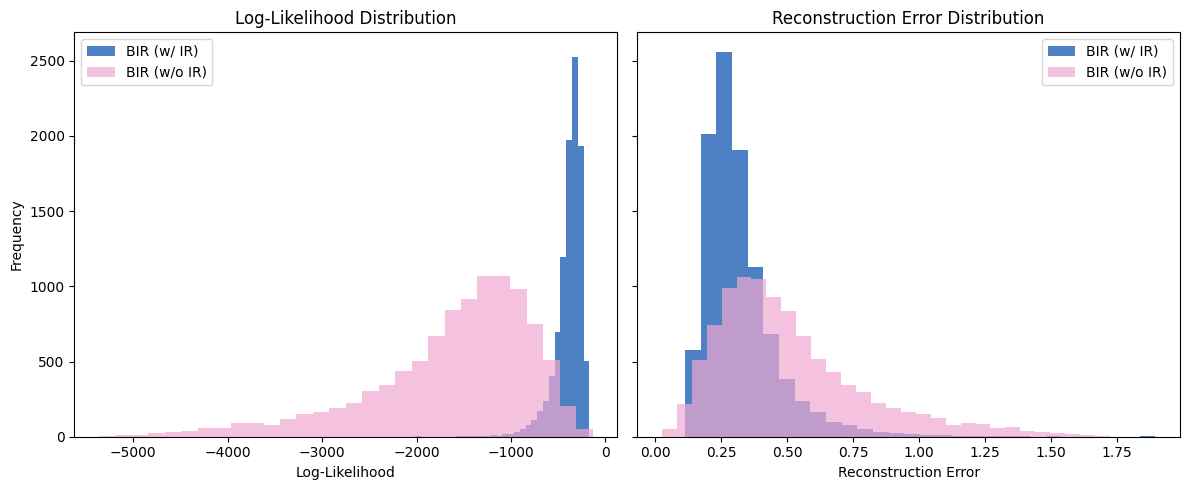

In [102]:
# Plot 2: Histograms for LL and RE distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

axes[0].hist(ll_per_datapoint_with_replay, bins=30, alpha=0.7, label='BIR (w/ IR)',color=with_replay_color)
axes[0].hist(ll_per_datapoint_without_replay, bins=30, alpha=0.7, label='BIR (w/o IR)', color=without_replay_color)
# axes[0].hist(ll_per_datapoint_with_replay_si, bins=30, alpha=0.7, label='With Replay',color=with_replay_color_si)
# axes[0].hist(ll_per_datapoint_without_replay_si, bins=30, alpha=0.7, label='Without Replay', color=without_replay_color_si)
axes[0].set_title('Log-Likelihood Distribution')
axes[0].set_xlabel('Log-Likelihood')
axes[0].set_ylabel('Frequency')
axes[0].legend()

axes[1].hist(re_per_datapoint_with_replay, bins=30, alpha=0.7, label='BIR (w/ IR)',color=with_replay_color)
axes[1].hist(re_per_datapoint_without_replay, bins=30, alpha=0.7, label='BIR (w/o IR)', color=without_replay_color)
# axes[1].hist(re_per_datapoint_with_replay_si, bins=30, alpha=0.7, label='With Replay',color=with_replay_color_si)
# axes[1].hist(re_per_datapoint_without_replay_si, bins=30, alpha=0.7, label='Without Replay', color=without_replay_color_si)
axes[1].set_title('Reconstruction Error Distribution')
axes[1].set_xlabel('Reconstruction Error')
axes[1].legend()

os.makedirs("./store/fig/", exist_ok=True)
plt.savefig(f"./store/fig/log_likelihood_reconstruction_error.pdf")

plt.tight_layout()
%matplotlib inline
plt.show()


### 2. Analysis using t-SNE, UMAP

In [57]:
for name, module in trained_model_with_replay.named_modules():
    print(f"{name}, Module: {module}")
    break

, Module: AutoEncoder(
  (convE): ConvLayers(
    (convLayer1): conv_layer(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nl): ReLU()
    )
    (convLayer2): conv_layer(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nl): ReLU()
    )
    (convLayer3): conv_layer(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nl): ReLU()
    )
    (convLayer4): conv_layer(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nl): ReLU()
    )
    (convLayer5): conv_layer(
      (conv): C

In [58]:
for name, module in trained_model_with_replay.named_modules():
    print(f"{name}")


convE
convE.convLayer1
convE.convLayer1.conv
convE.convLayer1.bn
convE.convLayer1.nl
convE.convLayer2
convE.convLayer2.conv
convE.convLayer2.bn
convE.convLayer2.nl
convE.convLayer3
convE.convLayer3.conv
convE.convLayer3.bn
convE.convLayer3.nl
convE.convLayer4
convE.convLayer4.conv
convE.convLayer4.bn
convE.convLayer4.nl
convE.convLayer5
convE.convLayer5.conv
convE.convLayer5.nl
convE.pooling
flatten
fcE
fcE.fcLayer1
fcE.fcLayer1.linear
fcE.fcLayer1.nl
fcE.fcLayer2
fcE.fcLayer2.linear
fcE.fcLayer2.nl
toZ
toZ.mean
toZ.mean.linear
toZ.logvar
toZ.logvar.linear
classifier
classifier.linear
fromZ
fromZ.linear
fromZ.nl
fcD
fcD.fcLayer1
fcD.fcLayer1.linear
fcD.fcLayer1.nl
fcD.fcLayer2
fcD.fcLayer2.linear
to_image
convD


In [88]:
import torch

def extract_activations(model, dataloader, layer_name, device="cuda"):
    activations = []
    labels = []

    # Hook to capture activations
    def hook(module, input, output):
        activations.append(output.detach().cpu().numpy())  # Always store activations on CPU for visualization

    # Register the hook
    handle = dict(model.named_modules())[layer_name].register_forward_hook(hook)

    # Ensure the model is on the correct device
    model.to(device)

    # Run data through the model
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to the same device as the model
        
        with torch.no_grad():
            model.classify(inputs, not_hidden=True)  # Forward pass
            labels.append(targets.cpu().numpy())  # Store labels on CPU for visualization

    handle.remove()  # Remove the hook after extraction

    # Combine results
    # activations = np.concatenate(activations, axis=0)
    # labels = np.concatenate(labels, axis=0)
    return activations, labels


# Visualization function remains unchanged
def visualize_embeddings(activations, labels, method="tsne", title="", layer_name="", type=None, task=0):
    if method == "tsne":
        reducer = TSNE(n_components=2, random_state=42)
    elif method == "umap":
        reducer = umap.UMAP(n_components=2, random_state=42)
        # reducer = umap.UMAP(metric="cosine", n_neighbors=15, random_state=42)
    elif method == "PCA":
        from sklearn.decomposition import PCA
        reducer = PCA(n_components=2)
    elif method == "lda":
        from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
        reducer = LinearDiscriminantAnalysis(n_components=2)
    else:
        raise ValueError("Invalid method. Use 'tsne' or 'umap'.")

    import numpy as np

    # Combine the activations list into a single array
    # activations = np.concatenate(activations, axis=0)
    # print(activations.shape)
    
    if type == "normalize":
        from sklearn.preprocessing import StandardScaler
        activations = StandardScaler().fit_transform(activations)
    elif type == "pca":
        from sklearn.decomposition import PCA
        pca = PCA(n_components=50)
        activations = pca.fit_transform(activations)

    embeddings = reducer.fit_transform(activations)
    plt.figure(figsize=(10, 8))
    # scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1], c=np.concatenate(labels, axis=0), cmap="tab10", alpha=0.7, s=10)
    scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap="tab10", alpha=0.7, s=10)
    # plt.colorbar(scatter, label="Class Labels")
    # plt.title(title)
    # plt.xlabel("Dimension 1")
    # plt.ylabel("Dimension 2")
    
    os.makedirs(f"./store/fig/{task}", exist_ok=True)
    plt.savefig(f"./store/fig/{task}/{title}_{method}_{layer_name}.pdf")   
    
    %matplotlib inline
    plt.show()
    

    
    from sklearn.metrics import silhouette_score
    # print('emb ', embeddings.shape)
    # print('label ', labels.shape)
    # silhouette = silhouette_score(embeddings, labels)
    # print("Silhouette Score:", silhouette)



# def visualize_embeddings(activations, labels, method="tsne", title=""):
#     if method == "tsne":
#         reducer = TSNE(n_components=2, random_state=42)
#     elif method == "umap":
#         reducer = umap.UMAP(n_components=2, random_state=42)
#     else:
#         raise ValueError("Invalid method. Use 'tsne' or 'umap'.")

#     import numpy as np

#     # Combine the activations list into a single array
#     # activations = np.concatenate(activations, axis=0)
#     # print(activations.shape)
    
#     embeddings = reducer.fit_transform(activations)
#     plt.figure(figsize=(10, 8))
#     scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap="tab10", alpha=0.7, s=10)
#     plt.colorbar(scatter, label="Class Labels")
#     plt.title(title)
#     plt.xlabel("Component 1")
#     plt.ylabel("Component 2")
#     %matplotlib inline
#     plt.show()

def final(activations_with_replay, labels_with_replay):
    activations_with_replay = np.stack(activations_with_replay[:-1])
    activations_with_replay = torch.tensor(activations_with_replay).reshape(-1, activations_with_replay.shape[-1])
    
    labels_with_replay = np.stack(labels_with_replay[:-1])
    labels_with_replay = torch.tensor(labels_with_replay).view(-1)
    
    return activations_with_replay, labels_with_replay
    

def run(layer_name, method="umap", type=None):
    for i in range(dict_without_replay['args'].tasks):  # Iterate through tasks
        task_id = i + 1
        task_loader = utils.get_data_loader(test_datasets[i], batch_size=128, cuda=trained_model_with_replay._is_on_cuda()) 

        # Ensure models are on the correct device
        device = "cuda" if torch.cuda.is_available() else "cpu"
        trained_model_with_replay.to(device)
        trained_model_without_replay.to(device)
        
        # Extract activations
        activations_with_replay, labels_with_replay = extract_activations(
            trained_model_with_replay, task_loader, layer_name, device=device
        )
        activations_without_replay, labels_without_replay = extract_activations(
            trained_model_without_replay, task_loader, layer_name, device=device
        )
        
        activations_with_replay_si, labels_with_replay_si = extract_activations(
            trained_model_with_replay_si, task_loader, layer_name, device=device
        )
        activations_without_replay_si, labels_without_replay_si = extract_activations(
            trained_model_without_replay_si, task_loader, layer_name, device=device
        )
        
        activations_with_replay, labels_with_replay = final(activations_with_replay, labels_with_replay)
        activations_without_replay, labels_without_replay = final(activations_without_replay, labels_without_replay)
        
        activations_with_replay_si, labels_with_replay_si = final(activations_with_replay_si, labels_with_replay_si)
        activations_without_replay_si, labels_without_replay_si = final(activations_without_replay_si, labels_without_replay_si)
        
        
        
        # print('activations_with_replay ', activations_with_replay.shape)
        # print('labels_with_replay ', labels_with_replay.shape)
        
        # print('activations_without_replay ', activations_without_replay.shape)
        # print('labels_without_replay ', labels_without_replay.shape)
        #####
        
        # activations_with_replay = np.concatenate(activations_with_replay, axis=0)
        # activations_without_replay = torch.tensor(activations_without_replay)
        # for i, arr in enumerate(activations_without_replay):
        #     print(f"Shape of array {i}: {arr.shape}")

        # print('activations_with_replay ', (activations_without_replay))
        # print('labels_with_replay ', (labels_with_replay).sort())
        # print('==========')
        
        if i == 6:
            # Visualize embeddings
            visualize_embeddings(
                activations_with_replay, labels_with_replay, method=method,
                title=f"Task {task_id} - With Replay", layer_name=layer_name, type=type, task=i
            )
            visualize_embeddings(
                activations_without_replay, labels_without_replay, method=method,
                title=f"Task {task_id} - Without Replay", layer_name=layer_name, type=type, task=i
            )
            visualize_embeddings(
                activations_with_replay_si, labels_with_replay_si, method=method,
                title=f"Task {task_id} - With Replay (bir+si)", layer_name=layer_name, type=type, task=i
            )
            visualize_embeddings(
                activations_without_replay_si, labels_without_replay_si, method=method,
                title=f"Task {task_id} - Without Replay (bir+si)", layer_name=layer_name, type=type, task=i
            )



In [68]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

def calculate_silhouette_scores(layer_name, method="umap", type=None):
    silhouette_scores_with_replay = []
    silhouette_scores_without_replay = []
    silhouette_scores_with_replay_si = []
    silhouette_scores_without_replay_si = []

    for i in range(dict_without_replay['args'].tasks):  # Iterate through tasks
        task_id = i + 1
        task_loader = utils.get_data_loader(test_datasets[i], batch_size=128, cuda=trained_model_with_replay._is_on_cuda())

        # Ensure models are on the correct device
        device = "cuda" if torch.cuda.is_available() else "cpu"
        trained_model_with_replay.to(device)
        trained_model_without_replay.to(device)

        # Extract activations
        activations_with_replay, labels_with_replay = extract_activations(
            trained_model_with_replay, task_loader, layer_name, device=device
        )
        activations_without_replay, labels_without_replay = extract_activations(
            trained_model_without_replay, task_loader, layer_name, device=device
        )
        
        activations_with_replay_si, labels_with_replay_si = extract_activations(
            trained_model_with_replay_si, task_loader, layer_name, device=device
        )
        activations_without_replay_si, labels_without_replay_si = extract_activations(
            trained_model_without_replay_si, task_loader, layer_name, device=device
        )
        
        activations_with_replay, labels_with_replay = final(activations_with_replay, labels_with_replay)
        activations_without_replay, labels_without_replay = final(activations_without_replay, labels_without_replay)
        
        activations_with_replay_si, labels_with_replay_si = final(activations_with_replay_si, labels_with_replay_si)
        activations_without_replay_si, labels_without_replay_si = final(activations_without_replay_si, labels_without_replay_si)

        # Optional preprocessing
        if type == "normalize":
            from sklearn.preprocessing import StandardScaler
            activations_with_replay = StandardScaler().fit_transform(activations_with_replay)
            activations_without_replay = StandardScaler().fit_transform(activations_without_replay)
            activations_with_replay_si = StandardScaler().fit_transform(activations_with_replay_si)
            activations_without_replay_si = StandardScaler().fit_transform(activations_without_replay_si)
        elif type == "pca":
            from sklearn.decomposition import PCA
            pca = PCA(n_components=50)
            activations_with_replay = pca.fit_transform(activations_with_replay)
            activations_without_replay = pca.fit_transform(activations_without_replay)
            activations_with_replay_si = pca.fit_transform(activations_with_replay_si)
            activations_without_replay_si = pca.fit_transform(activations_without_replay_si)

        # Apply dimensionality reduction
        if method == "umap":
            import umap
            reducer = umap.UMAP(n_components=2, random_state=42)
        elif method == "tsne":
            from sklearn.manifold import TSNE
            reducer = TSNE(n_components=2, random_state=42)
        elif method == "PCA":
            from sklearn.decomposition import PCA
            reducer = PCA(n_components=2)
        else:
            raise ValueError("Invalid method. Use 'umap' or 'tsne'.")

        embeddings_with_replay = reducer.fit_transform(activations_with_replay)
        embeddings_without_replay = reducer.fit_transform(activations_without_replay)
        embeddings_with_replay_si = reducer.fit_transform(activations_with_replay_si)
        embeddings_without_replay_si = reducer.fit_transform(activations_without_replay_si)

        # Calculate silhouette scores
        silhouette_with = silhouette_score(embeddings_with_replay, labels_with_replay)
        silhouette_without = silhouette_score(embeddings_without_replay, labels_without_replay)

        silhouette_scores_with_replay.append(silhouette_with)
        silhouette_scores_without_replay.append(silhouette_without)
        
        silhouette_with_si = silhouette_score(embeddings_with_replay_si, labels_with_replay_si)
        silhouette_without_si = silhouette_score(embeddings_without_replay_si, labels_without_replay_si)

        silhouette_scores_with_replay_si.append(silhouette_with_si)
        silhouette_scores_without_replay_si.append(silhouette_without_si)

    return silhouette_scores_with_replay, silhouette_scores_without_replay, silhouette_scores_with_replay_si, silhouette_scores_without_replay_si, method


In [69]:
layer_name ='fcE.fcLayer2.linear'

In [70]:

silhouette_scores_with_replay, silhouette_scores_without_replay, silhouette_scores_with_replay_si, silhouette_scores_without_replay_si, method \
    = calculate_silhouette_scores(layer_name)

/home/jina/anaconda3/envs/brain_sub/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/jina/anaconda3/envs/brain_sub/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/jina/anaconda3/envs/brain_sub/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/jina/anaconda3/envs/brain_sub/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/jina/anaconda3/envs/brain_sub/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/jina/anaconda3/envs/brain_sub/lib/python3.9/

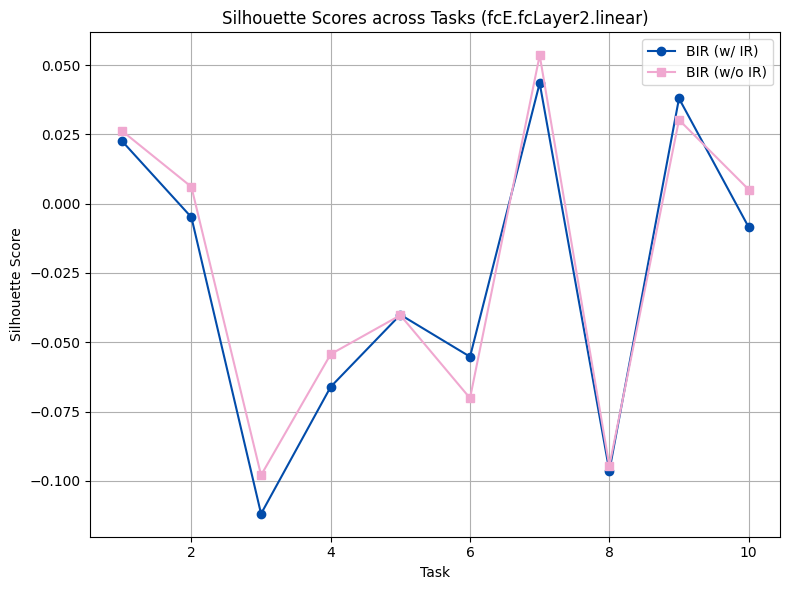

In [103]:
# Plot the silhouette scores
tasks = list(range(1, len(silhouette_scores_with_replay) + 1))
plt.figure(figsize=(8, 6))
plt.plot(tasks, silhouette_scores_with_replay, marker="o", label="BIR (w/ IR)", linestyle="-", color=with_replay_color)
plt.plot(tasks, silhouette_scores_without_replay, marker="s", label="BIR (w/o IR)", linestyle="-", color=without_replay_color)
# plt.plot(tasks, silhouette_scores_with_replay_si, marker="o", label="With Replay (bir+si)", linestyle="-", color=with_replay_color_si)
# plt.plot(tasks, silhouette_scores_without_replay_si, marker="s", label="Without Replay (bir+si)", linestyle="--", color=without_replay_color_si)
plt.title(f"Silhouette Scores across Tasks ({layer_name})")
plt.xlabel("Task")
plt.ylabel("Silhouette Score")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the plot
os.makedirs("./store/fig/", exist_ok=True)
plt.savefig(f"./store/fig/silhouette_comparison_{layer_name}_{method}.pdf")
%matplotlib inline
plt.show()

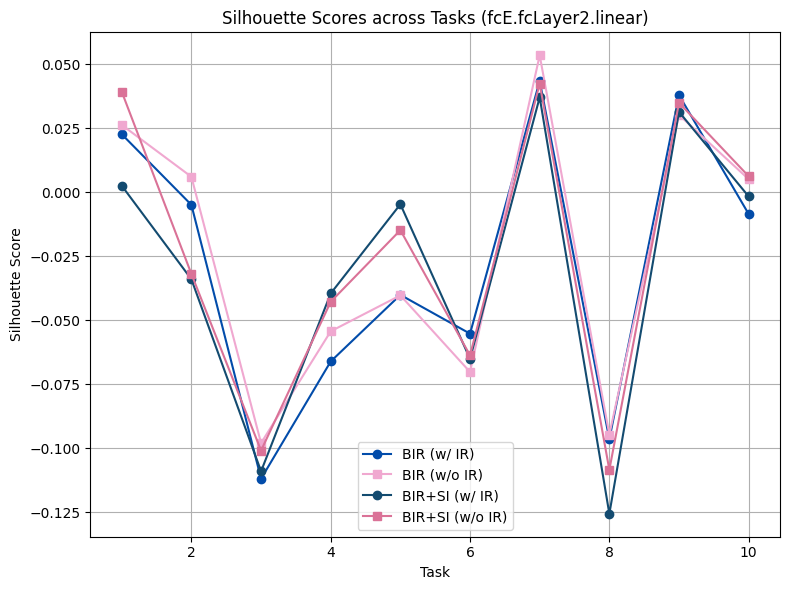

In [104]:
# Plot the silhouette scores
tasks = list(range(1, len(silhouette_scores_with_replay) + 1))
plt.figure(figsize=(8, 6))
plt.plot(tasks, silhouette_scores_with_replay, marker="o", label="BIR (w/ IR)", linestyle="-", color=with_replay_color)
plt.plot(tasks, silhouette_scores_without_replay, marker="s", label="BIR (w/o IR)", linestyle="-", color=without_replay_color)
plt.plot(tasks, silhouette_scores_with_replay_si, marker="o", label="BIR+SI (w/ IR)", linestyle="-", color=with_replay_color_si)
plt.plot(tasks, silhouette_scores_without_replay_si, marker="s", label="BIR+SI (w/o IR)", linestyle="-", color=without_replay_color_si)
plt.title(f"Silhouette Scores across Tasks ({layer_name})")
plt.xlabel("Task")
plt.ylabel("Silhouette Score")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the plot
os.makedirs("./store/fig/", exist_ok=True)
plt.savefig(f"./store/fig/silhouette_comparison_{layer_name}_{method}_all.pdf")
%matplotlib inline
plt.show()

/home/jina/anaconda3/envs/brain_sub/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


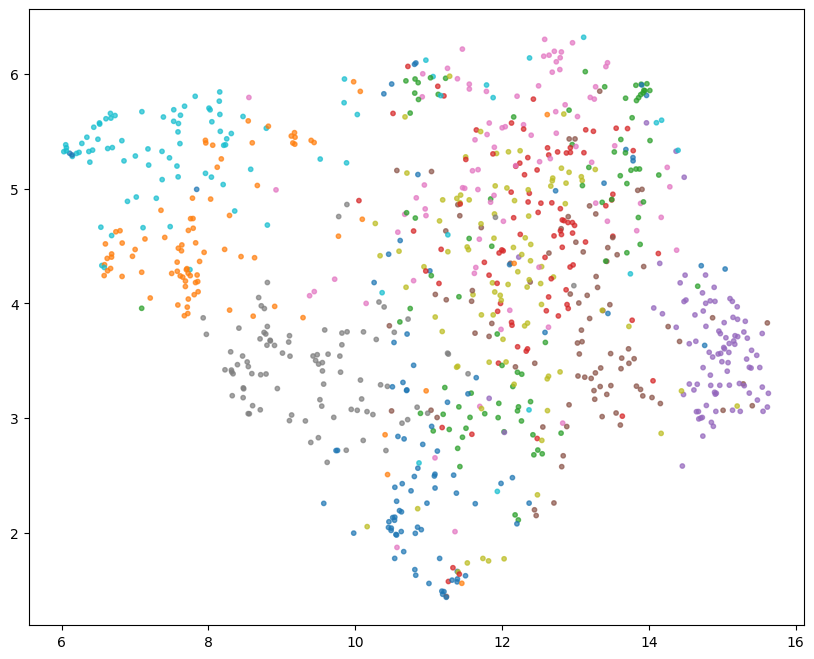

/home/jina/anaconda3/envs/brain_sub/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


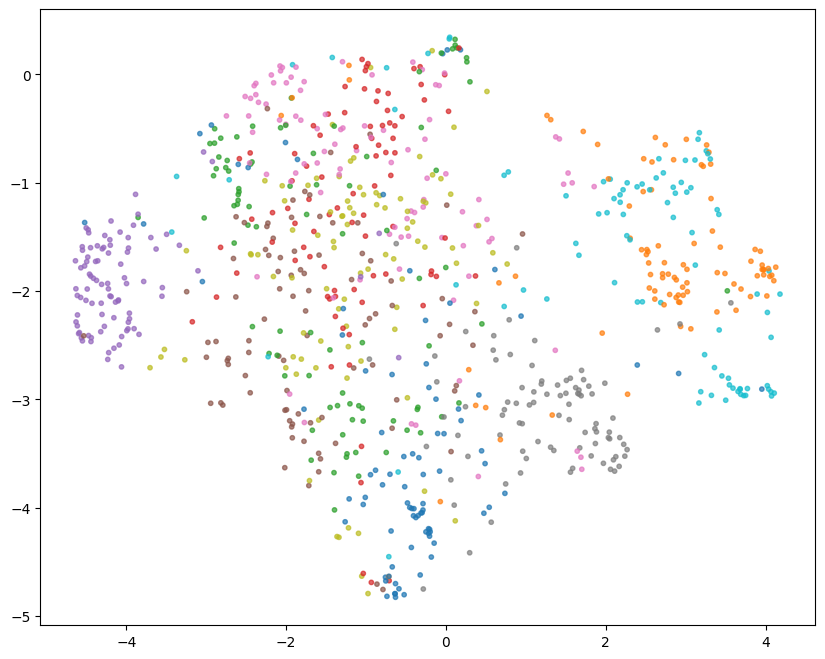

/home/jina/anaconda3/envs/brain_sub/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


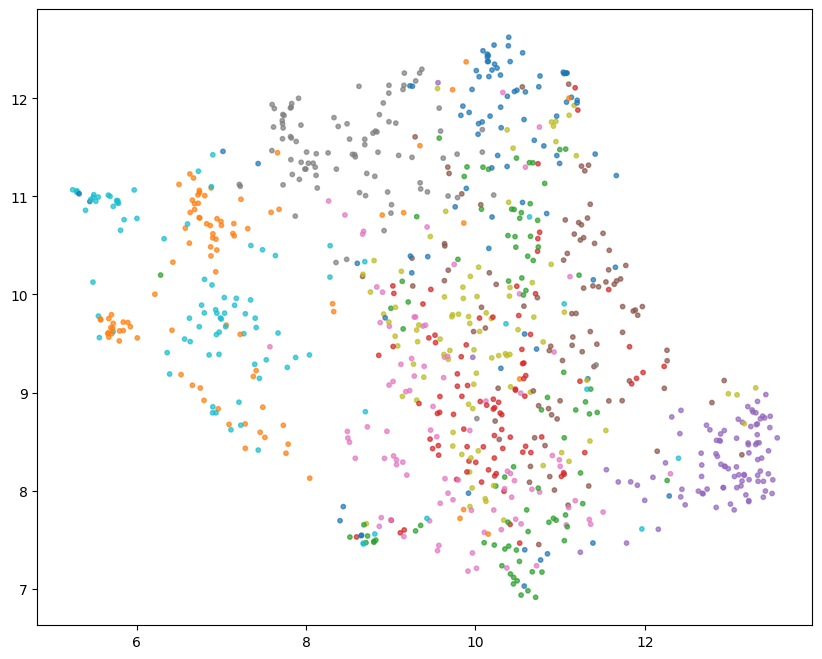

/home/jina/anaconda3/envs/brain_sub/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


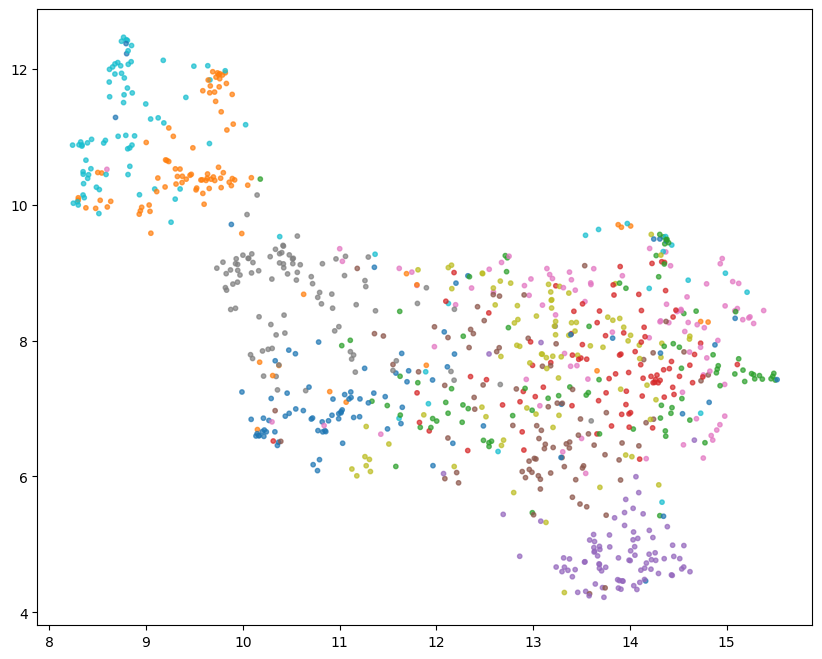

In [93]:
run(layer_name)